In [66]:
import sys 
sys.path.append('./model')

import argparse 
import torch
import numpy as np
from model.model import NCNet
import torchvision.transforms as transforms
from dataloader import TrainLoader, ValLoader
from loss import WeakLoss
import torch.optim as optim
import json 
import os 
from torchvision import transforms
import pandas as pd
import PIL.Image as Image


import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline

## Function to plot correspondence
def plotCorres(IA, IB, xA, yA, xB, yB, score = [], scoreTH = 0.5, lineColor = 'green') : 
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    wA, hA = IA.size
    wB, hB = IB.size
    nbPoint = len(xA)
    
    ax1.imshow(np.array(IA))
    ax2.imshow(np.array(IB))

    for i in range(nbPoint) : 
        if len(score) >0 and score[i] < scoreTH :
            continue
        xyA = (int(xA[i] * wA),int(yA[i] * hA))
        xyB = (int(xB[i] * wB),int(yB[i] * hB))

        con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                              axesA=ax2, axesB=ax1, color=lineColor, linewidth = 3)
        ax2.add_artist(con)

        ax1.plot(xyA[0],xyA[1],'ro',markersize=5)
        ax2.plot(xyB[0],xyB[1],'ro',markersize=5)


    plt.show()

## Function resize
def resizeImg(I, minNet, strideNet, maxSize = 1000.) :

    w, h = I.size
    ## resize img, the largest dimension is maxSize
    wratio, hratio = w / maxSize, h / maxSize
    resizeRatio = max(wratio, hratio)
    
    w, h= w / resizeRatio, h / resizeRatio
    
    resizeW = round((w - minNet) / strideNet) * strideNet  + minNet
    resizeH = round((h - minNet) / strideNet) * strideNet + minNet
    
    
    return I.resize((resizeW, resizeH))

### Load model, set global paramters

In [67]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet normalization
testTransform = transforms.Compose([transforms.ToTensor(), 
                                     normalize,])

neighConsKernel = [5,5,5]
neighConsChannel = [16,16,1]
featExtractor = 'ResNet18Conv4'
featExtractorPth = './model/FeatureExtractor/resnet18.pth'
finetuneFeatExtractor = False
softmaxMM = True
resumePth = './pascalConv4Softmax/netBest-0.232.pth'
if featExtractor == 'ResNet18Conv4' : 
    minNet = 15
    strideNet = 16
elif featExtractor == 'ResNet18Conv5' : 
    minNet = 31
    strideNet = 32

scoreTH = 0.5 
sigma = 0.01
nbWeightdPoint = 4
alpha = 0.1 

model = NCNet(kernel_sizes=neighConsKernel, 
              channels=neighConsChannel, 
              featExtractor = featExtractor, 
              featExtractorPth = featExtractorPth, 
              finetuneFeatExtractor = finetuneFeatExtractor,
              softmaxMutualMatching = softmaxMM)
model.load_state_dict(torch.load(resumePth))
model.cuda()
model.eval()

Loading weight from ./model/FeatureExtractor/resnet18.pth

Set Feature Extraction to validation mode...


NCNet(
  (featExtractor): ResNetConv4(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

### Plot annotated correspondences

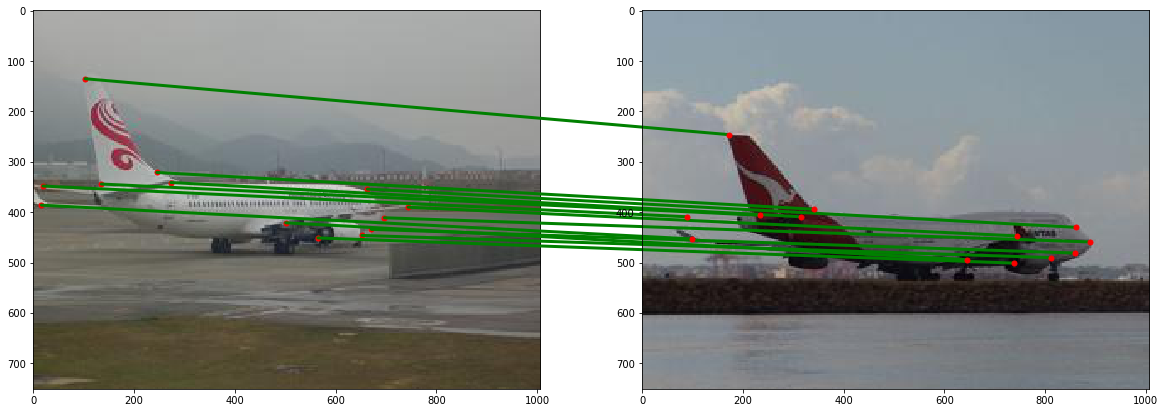

In [68]:
index = 2
imgDir = 'data/pf-pascal/JPEGImages/'
df = pd.read_csv('data/pf-pascal/test.csv')
imgA = df['source_image'][ index ]
imgB = df['target_image'][ index ]

IA = Image.open(os.path.join(imgDir, imgA)).convert('RGB')
wA, hA = IA.size
IB = Image.open(os.path.join(imgDir, imgB)).convert('RGB')
wB, hB = IB.size

xA = np.array(list(map(float, df['XA'][ index ].split(';')))) / wA
yA = np.array(list(map(float, df['YA'][ index ].split(';')))) / hA
xB = np.array(list(map(float, df['XB'][ index ].split(';')))) / wB
yB = np.array(list(map(float, df['YB'][ index ].split(';')))) / hB



# compute PCK reference length refPCK (equal to max bounding box side in image_A)
refPCK = max(xA.max() - xA.min(), yA.max() - yA.min())

IA = resizeImg (IA, minNet, strideNet)
IB = resizeImg (IB, minNet, strideNet)

# Plot
plotCorres(IA, IB, xA, yA, xB, yB)



### Plot Mutual Matching (with thresholding the score)

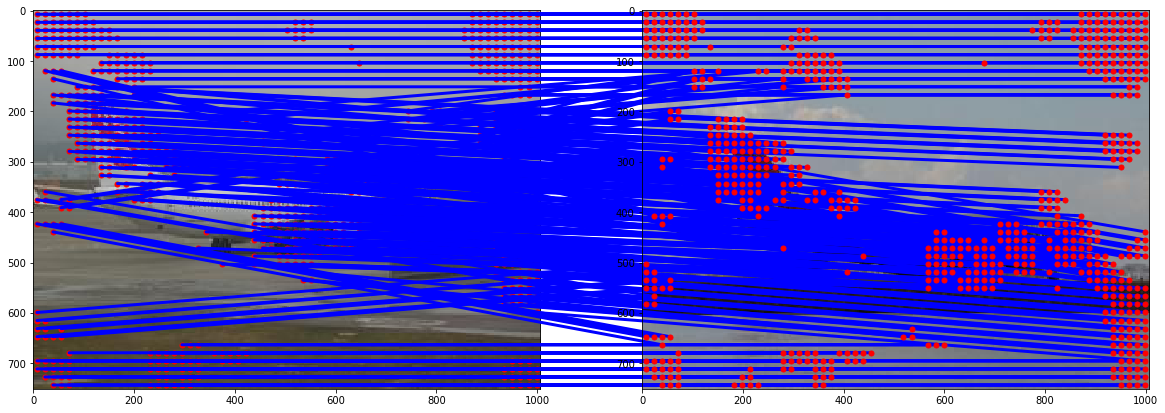

In [70]:
featA = testTransform(IA)
featB = testTransform(IB)
featA = featA.unsqueeze(0).cuda()
featB = featB.unsqueeze(0).cuda()
with torch.no_grad() : 
    corr4D = model(featA, featB)
_, _, wA, hA, wB, hB = corr4D.size()
corr4D = corr4D.view(wA * hA, wB * hB)
scoreA, posA = corr4D.topk(k=1, dim = 1)
scoreB, posB = corr4D.topk(k=1, dim = 0)
top1ScoreA = torch.cuda.FloatTensor(wA * hA, wB * hB).fill_(0).scatter_(1, posA, scoreA)
top1ScoreB = torch.cuda.FloatTensor(wA * hA, wB * hB).fill_(0).scatter_(0, posB, scoreB)

## top1 score for mutual matching
top1ScoreMM = (top1ScoreA * top1ScoreB) ** 0.5
indexMM = top1ScoreMM.nonzero()
scoreMM = torch.masked_select(top1ScoreMM, top1ScoreMM > 0)

indexMM, scoreMM = indexMM.cpu().numpy(), scoreMM.cpu().numpy()
posYA, posXA, posYB, posXB  = ((indexMM[:, 0] / hA).astype(int) + 0.5) / float(wA), (indexMM[:, 0] % hA + 0.5) / float(hA), ((indexMM[:, 1] / hB).astype(int) + 0.5) / float(wB), (indexMM[:, 1] % hB + 0.5) / float(hB) 
plotCorres(IA, IB, posXA, posYA, posXB, posYB, scoreMM, scoreTH, lineColor = 'blue')

### Plot matching with given key points in Image B

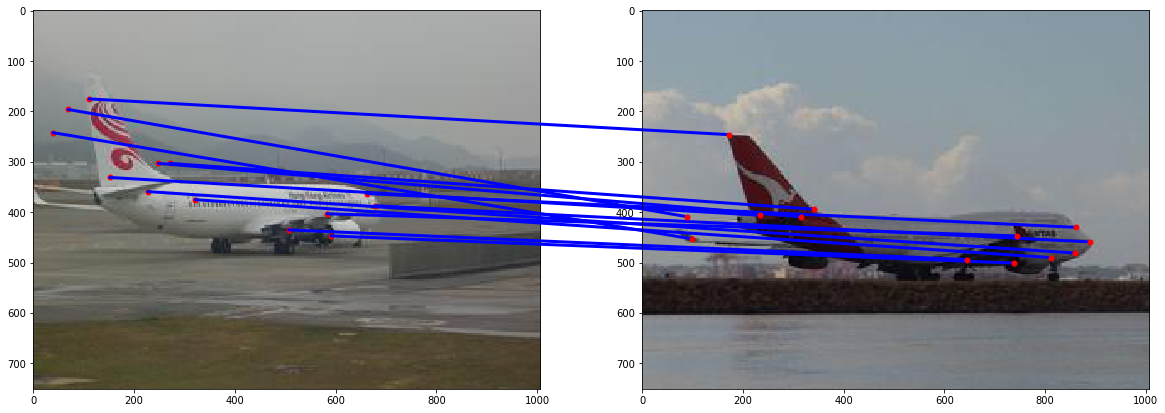

In [71]:
pairwiseDist = ((xB.reshape((-1, 1)) - posXB.reshape((1, -1))) ** 2 +  (yB.reshape((-1, 1)) - posYB.reshape((1, -1))) ** 2)
pairwiseDist = np.exp(-1 * pairwiseDist /2 / sigma)
weight = pairwiseDist * scoreMM.reshape((1, -1))
indexSorted = np.argsort(-1 * weight, axis=1)
wrapPointxA = np.zeros(len(xA))
wrapPointyA = np.zeros(len(xA))
wrapScore = np.zeros(len(xA))

for i in range(len(xA)) : 
    indexInterPoint = indexSorted[i, :nbWeightdPoint]
    interPosXA, interPosYA, interScore = posXA[indexInterPoint], posYA[indexInterPoint], scoreMM[indexInterPoint]
    interWeight = weight[i, indexInterPoint]
    
    interWeight = interWeight / interWeight.sum()
    wrapPointxA[i], wrapPointyA[i], wrapScore[i] = np.sum(interWeight * interPosXA), np.sum(interWeight * interPosYA), np.sum(interWeight * interScore)

plotCorres(IA, IB, wrapPointxA, wrapPointyA, xB, yB, lineColor = 'blue')

In [72]:
prec = np.mean(((wrapPointxA - xA) ** 2 + (wrapPointyA - yA) ** 2) ** 0.5 < refPCK * alpha)
msg = 'PCK {:.4f}'.format(prec)
print (msg)

PCK 0.6154
